# Evaluating latent factors and firing rates inferred by `lfads-torch`
Now that you have trained an lfads-torch multissession model. Let's walk through how to evaluate the performance of this kind of model using the Rouse reaching dataset introduced in `1_data_prep.ipynb`. We will do so by testing the generalizability of decoding velocity using the LFADS factors. We will also evaluate PSTHs and state space plots.
## Load the experimental data and drop trials with missing values

In [1]:
import re
from glob import glob
import numpy as np
from scipy.io import loadmat
from scipy.signal import lfilter
from scipy.signal.windows import gaussian

# Get the paths to all data files
DATA_PATHS = sorted(glob("AnimalP/P_Spikes_*-data_PSTH_prep_bin_20.mat"))
# Data is binned at 20 ms
bin_width_sec = 0.02
spikes = {}
conds = {}
velocity = {}
# Regex matches the dates in the file names
date_regex = re.compile(r"(2017\d{4})")
for data_path in DATA_PATHS:
    sess = date_regex.findall(data_path)[0]
    data = loadmat(data_path)
    # Load neural data, conditions, and behavior
    spikes[sess] = data["spikes_peakVel"].swapaxes(0, 2) * bin_width_sec
    conds[sess] = data["conditionID_peakVel"].squeeze() - 1
    velocity[sess] = np.gradient(data["JoystickPos_peakVel"].swapaxes(0, 2), axis=1)
# Drop all trials with missing data
for sess in spikes:
    valid_trials = ~np.isnan(spikes[sess]).any(axis=(1, 2))
    spikes[sess] = spikes[sess][valid_trials]
    conds[sess] = conds[sess][valid_trials]
    velocity[sess] = velocity[sess][valid_trials]
# Perform smoothing (see 1_data_prep.ipynb)
std = 0.02 / bin_width_sec
window = gaussian(std * 3 * 2, std)
window /= window.sum()
smth_spikes = {}
for sess in spikes:
    smth = lfilter(window, 1, spikes[sess], axis=1)
    smth[:, :len(window)] = np.nan
    smth_spikes[sess] = np.roll(smth, -len(window) // 2, axis=1)
{sess: s.shape for sess, s in spikes.items()}

{'20170630': (1575, 30, 113),
 '20170703': (1847, 30, 122),
 '20170705': (1707, 30, 133),
 '20170706': (1226, 30, 108),
 '20170712': (1164, 30, 104),
 '20170713': (1522, 30, 97),
 '20170714': (1331, 30, 124),
 '20170717': (1296, 30, 87),
 '20170720': (1569, 30, 94),
 '20170731': (1276, 30, 96),
 '20170801': (1386, 30, 122),
 '20170802': (1523, 30, 93)}

# Load LFADS factors and rates from output files

In [2]:
import numpy as np
import h5py

def merge_train_valid(train_data, valid_data, train_inds, valid_inds):
    n_samples = len(train_data) + len(valid_data)
    merged_data = np.full((n_samples, *train_data.shape[1:]), np.nan)
    merged_data[train_inds] = train_data
    merged_data[valid_inds] = valid_data
    return merged_data

# Get the paths to all data files
LFADS_OUTPUT_PATHS = sorted(glob("lfads-output/lfads_output_*.h5"))
# Data is binned at 20 ms
factors = {}
rates = {}
# Regex matches the dates in the file names
date_regex = re.compile(r"(2017\d{4})")
for data_path in LFADS_OUTPUT_PATHS:
    session = date_regex.findall(data_path)[0]
    with h5py.File(data_path) as f:
        # Merge train and valid data for factors and rates
        train_inds, valid_inds = f["train_inds"], f["valid_inds"]
        factors[session] = merge_train_valid(
            f["train_factors"],
            f["valid_factors"],
            train_inds,
            valid_inds,
        )
        rates[session] = merge_train_valid(
            f["train_output_params"],
            f["valid_output_params"],
            train_inds,
            valid_inds,
        ) / bin_width_sec
{sess: b.shape for sess, b in rates.items()}

{'20170630': (1575, 30, 113),
 '20170703': (1847, 30, 122),
 '20170705': (1707, 30, 133),
 '20170706': (1226, 30, 108),
 '20170712': (1164, 30, 104),
 '20170713': (1522, 30, 97),
 '20170714': (1331, 30, 124),
 '20170717': (1296, 30, 87),
 '20170720': (1569, 30, 94),
 '20170731': (1276, 30, 96),
 '20170801': (1386, 30, 122),
 '20170802': (1523, 30, 93)}

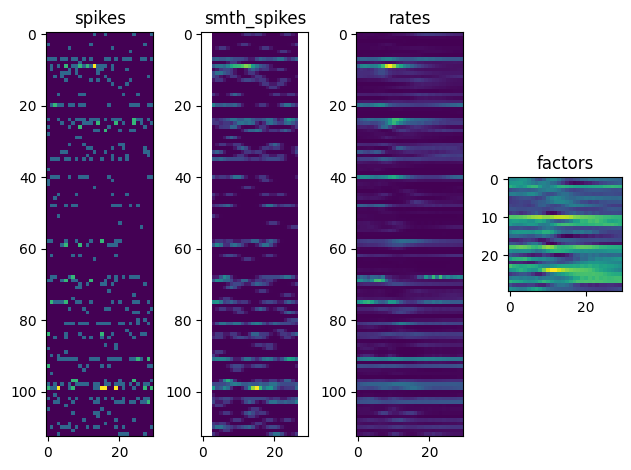

In [3]:
import matplotlib.pyplot as plt

# Visualize raw spikes, smoothed spikes, LFADS rates, and LFADS factors
session = "20170630"
trial = 0
data = {
    "spikes": spikes,
    "smth_spikes": smth_spikes,
    "rates": rates,
    "factors": factors,
}
fig, axes = plt.subplots(ncols=4)
for ax, (name, data_val) in zip(axes, data.items()):
    ax.imshow(data_val[session][trial].T)
    ax.set_title(name)
plt.tight_layout()

As an additional check, we can plot the PSTHs of the LFADS rates to verify if they are comparable to the empirical PSTHs obtained using smoothed spikes.
For simplicity, we do this for a single session and 20 neurons below.

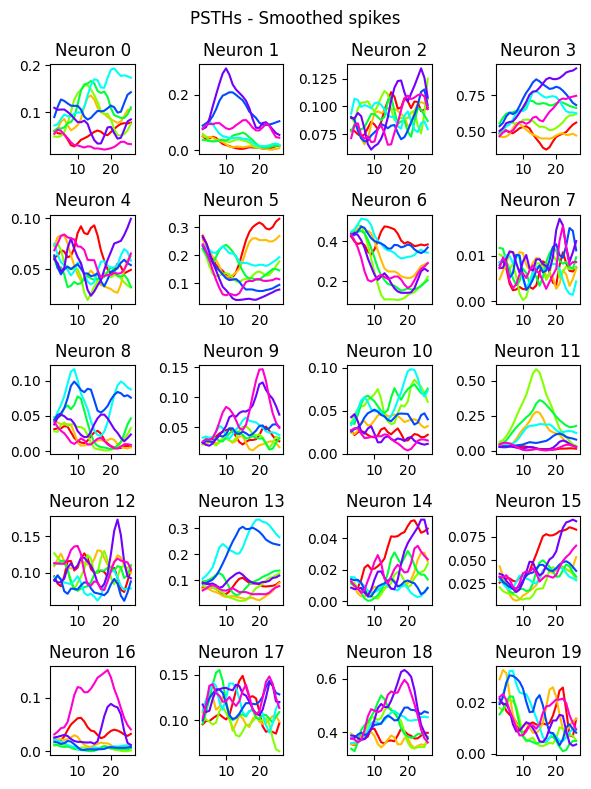

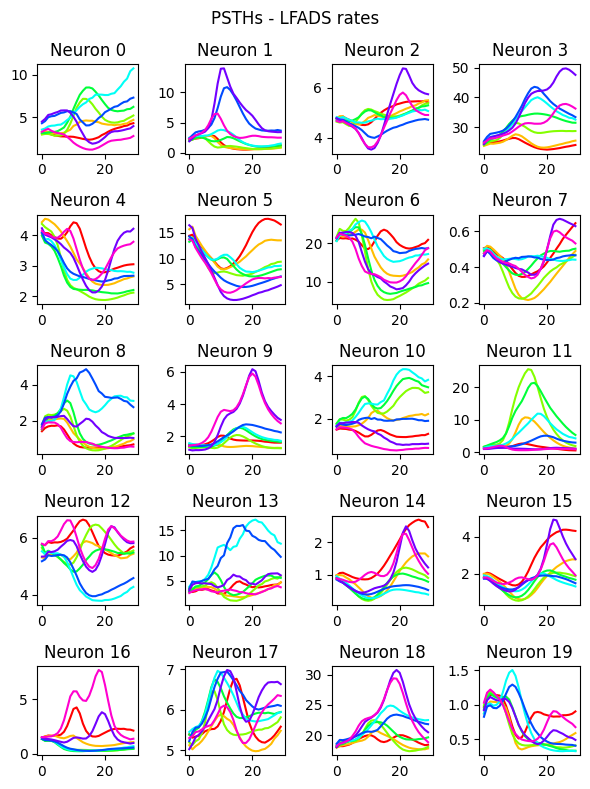

In [4]:
from matplotlib import cm

def plot_psths(data, conds, title):
    fig, axes = plt.subplots(5, 4, figsize=(6, 8))
    plot_conds = conds % 8
    for i, ax in enumerate(axes.flatten()):
        for c in np.unique(plot_conds):
            ax.plot(
                np.mean(data[plot_conds == c, :, i], axis=0),
                color=cm.hsv(c / 8),
            )
        ax.set_title(f"Neuron {i}")
    plt.suptitle(title)
    plt.tight_layout()

sess = "20170705"
plot_psths(smth_spikes[sess], conds[sess], "PSTHs - Smoothed spikes")
plot_psths(rates[sess], conds[sess], "PSTHs - LFADS rates")

In [5]:
# For convenience, drop decoding-related data where smoothed spikes are invalid
factors_masked = {}
for s in smth_spikes:
    mask = ~np.isnan(smth_spikes[s]).any((0, 2))
    smth_spikes[s] = smth_spikes[s][:, mask]
    factors_masked[s] = factors[s][:, mask]
    velocity[s] = velocity[s][:, mask]
{sess: v.shape for sess, v in velocity.items()}

{'20170630': (1575, 24, 2),
 '20170703': (1847, 24, 2),
 '20170705': (1707, 24, 2),
 '20170706': (1226, 24, 2),
 '20170712': (1164, 24, 2),
 '20170713': (1522, 24, 2),
 '20170714': (1331, 24, 2),
 '20170717': (1296, 24, 2),
 '20170720': (1569, 24, 2),
 '20170731': (1276, 24, 2),
 '20170801': (1386, 24, 2),
 '20170802': (1523, 24, 2)}

# Evaluate decoding performance
Here, we decode velocity from the neural data by training a separate linear decoder on each session and evaluating the performance on test trials from the same session. We refer to this as "within-day" decoding. We evaluate within-day decoding performance from LFADS factors to find the upper bound of decoding performance and also evaluate smoothed spikes as a reference point.

We are also interested in evaluating how well linear decoders trained on LFADS factors can generalize to held-out sessions ("across-day" decoding). For each session, we train the decoder on all other sessions and evaluate decoding performance on the held out session.

For both "within-day" and "across-day", we evaluate on all trials, non-corrective trials, and corrective trials as these subsets have different performance levels.

In [6]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import (
    train_test_split,
    GroupKFold,
    GridSearchCV,
)

n_lag = 5
cond_groups = {
    "All conditions": lambda x: x > -1,
    "Non-corrective conditions": lambda x: x <= 23,
    "Corrective conditions": lambda x: x >= 24,
}
data_types = {
    "LFADS factors": factors_masked,
    "Smoothed spikes": smth_spikes,
}
holdout_patterns = [
    "within-day",
    "across-day",
]
sessions = sorted(spikes.keys())
results = []
for cond_group, include_fn in cond_groups.items():
    for sess in sessions:
        for data_type, data in data_types.items():
            # Choose only trials of desired conditions and add decoding lag
            lag_incl_data = {
                s: d[include_fn(conds[s]), :-n_lag] for s, d in data.items()
            }
            lag_incl_vel = {
                s: v[include_fn(conds[s]), n_lag:] for s, v in velocity.items()
            }
            for ho_pattern in holdout_patterns:
                if ho_pattern == "within-day":
                    # Train and test on trials within the current session
                    x_train, x_test, y_train, y_test = train_test_split(
                        lag_incl_data[sess],
                        lag_incl_vel[sess],
                        test_size=0.2,
                        random_state=42,
                    )
                else:
                    if data_type == "Smoothed spikes":
                        # Can't decode across days due to dimensionality
                        continue
                    # Train on trials in other sessions, test on the current session
                    x_train = np.concatenate(
                        [lag_incl_data[s] for s in sessions if s != sess]
                    )
                    y_train = np.concatenate(
                        [lag_incl_vel[s] for s in sessions if s != sess]
                    )
                    x_test = lag_incl_data[sess]
                    y_test = lag_incl_vel[sess]
                # Use groups to perform train / valid split at the  trial level
                n_trials, n_timesteps, _ = x_train.shape
                groups = np.arange(n_trials)[..., np.newaxis]
                groups = np.repeat(groups, n_timesteps, axis=1).flatten()
                # Reshape the data for the estimator
                x_train_flat = x_train.reshape(-1, x_train.shape[-1])
                x_test_flat = x_test.reshape(-1, x_test.shape[-1])
                y_train_flat = y_train.reshape(-1, y_train.shape[-1])
                y_test_flat = y_test.reshape(-1, y_test.shape[-1])
                # Fit the models using a grid search over regularization parameters
                model = GridSearchCV(
                    Ridge(),
                    param_grid={"alpha": np.logspace(start=-1, stop=1, num=3)},
                    cv=GroupKFold(n_splits=5),
                )
                model.fit(x_train_flat, y_train_flat, groups=groups)
                score = model.score(x_test_flat, y_test_flat)
                # Save the results
                results.append(
                    {
                        "cond_group": cond_group,
                        "session": sess,
                        "data_type": f"{data_type} ({ho_pattern})",
                        "r2_score": score,
                    }
                )
pd.DataFrame(results)

,cond_group,session,data_type,r2_score
0,All conditions,20170630,LFADS factors (within-day),0.849588
1,All conditions,20170630,LFADS factors (across-day),0.835747
2,All conditions,20170630,Smoothed spikes (within-day),0.638460
3,All conditions,20170703,LFADS factors (within-day),0.831814
4,All conditions,20170703,LFADS factors (across-day),0.829748
...,...,...,...,...
103,Corrective conditions,20170801,LFADS factors (across-day),0.386689
104,Corrective conditions,20170801,Smoothed spikes (within-day),0.249488
105,Corrective conditions,20170802,LFADS factors (within-day),0.369808
106,Corrective conditions,20170802,LFADS factors (across-day),0.389194


We will plot the above results as a bar plot. 

If the model successfully found a common set of dynamics that describe all sessions, the held-out performance should be close to the held-in performance. Additionally, we expect the decoding performance from LFADS factors to exceed that of smoothed spikes.

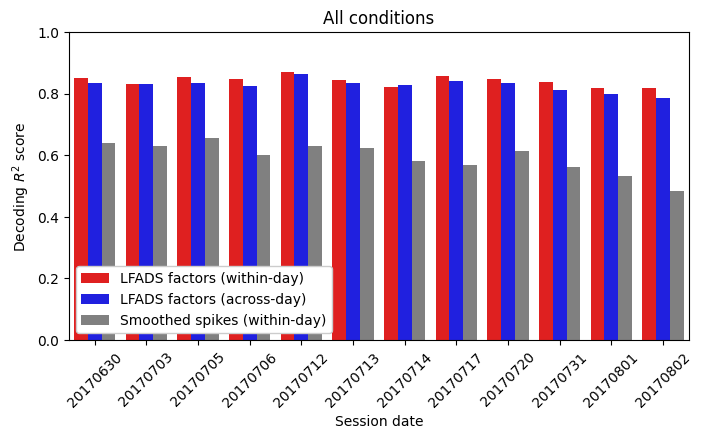

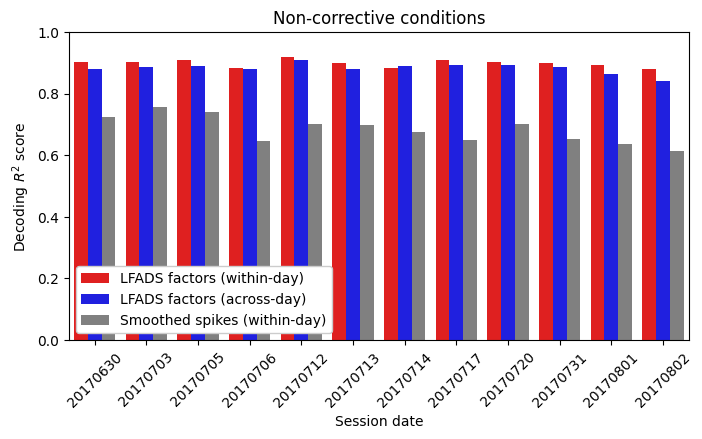

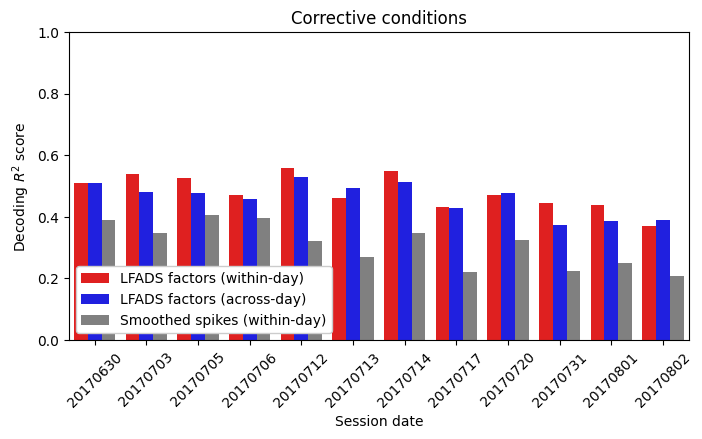

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
for cond_group in cond_groups:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(
        df[df.cond_group == cond_group],
        x="session",
        y="r2_score",
        hue="data_type",
        palette=["r", "b", "grey"],
        ax=ax,
    )
    ax.set_ylim(0, 1)
    ax.set_title(cond_group)
    ax.set_xlabel("Session date")
    ax.set_ylabel("Decoding $R^2$ score")
    ax.legend(loc="lower left", framealpha=1.0)
    ax.tick_params(axis='x', rotation=45)
    plt.show()

Lastly we will plot the state-space plot of the LFADS factors for each session in a 3D space by fitting PCA across all the sessions and then transforming each session individually. All the sessions should look similar to each other if the LFADS factors have generalized well across all the sessions. For the sake of visualization, here we will take only the initial trials.

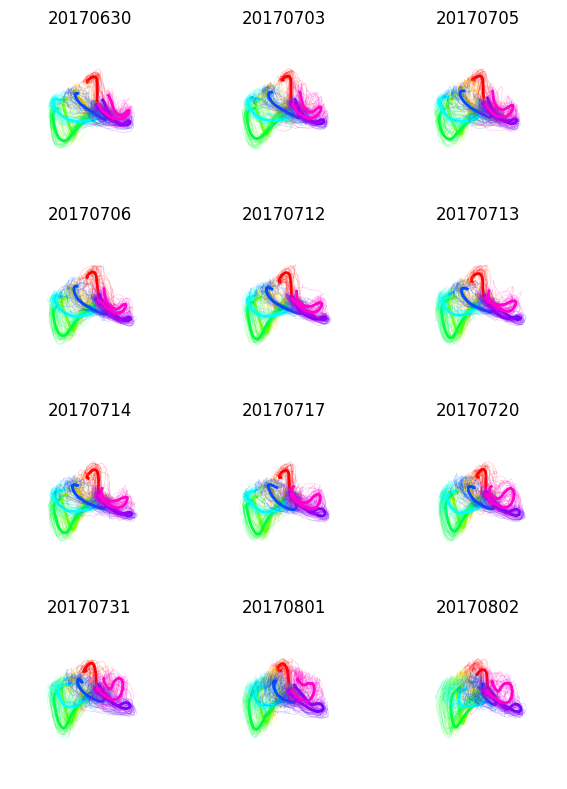

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create an array of 3D axes
fig = plt.figure(figsize=(6, 8))
nrows, ncols = 4, 3
axes = []
for i in range(nrows * ncols):
    axes.append(fig.add_subplot(nrows, ncols, i + 1, projection="3d"))
# Use only non-corrective conditions
factors_subset = {s: f[conds[s] <= 23] for s, f in factors.items()}
conds_subset = {s: c[c <= 23] for s, c in conds.items()}
# Perform PCA on all factors
all_factors_subset = np.concatenate([factors_subset[s] for s in sessions])
all_factors_subset = all_factors_subset.reshape(-1, all_factors_subset.shape[-1])
pca = PCA(n_components=3)
ss = StandardScaler()
pca.fit(ss.fit_transform(all_factors_subset))
# Plot the latent factors for each session
for i, sess in enumerate(sessions):
    # Apply PCA to the factors
    n_trials, n_timesteps, n_factors = factors_subset[sess].shape
    fac_subset_flat = factors_subset[sess].reshape(-1, n_factors)
    fac_subset_lowd = pca.transform(ss.fit_transform(fac_subset_flat))
    fac_subset_lowd = fac_subset_lowd.reshape(n_trials, n_timesteps, 3)
    # Plot according to reach direction
    conditions = conds_subset[sess] % 8
    unique_conds = np.unique(conditions)

    for c in unique_conds:
        fac_subset_lowd_cond = fac_subset_lowd[conditions == c]
        for t in range(30):
            axes[i].plot(
                *fac_subset_lowd_cond[t].T, 
                color=cm.hsv(c / len(unique_conds)),
                alpha=0.2,
                linewidth=0.5,
            )
        fac_subset_lowd_cond_avg = np.mean(fac_subset_lowd_cond, axis=0)
        axes[i].plot(
            *fac_subset_lowd_cond_avg.T[:3],
            color=cm.hsv(c / len(unique_conds)),
            alpha=1.0,
            linewidth=2,
        )
    axes[i].view_init(elev=15., azim=37.5)
    axes[i].axis('off')
    axes[i].set_title(sess)
fig.tight_layout()

We have now successfully trained and evaluated a multisession lfads-torch model! You can modify these notebooks to prepare, train, and evaluate your own data for multisession models. 